# Analyzing Key Indicators of Positive Reviews for iOS Apps 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import sklearn as sk
import chart_studio.plotly as py
import plotly.graph_objs as go
import seaborn as sns
from datetime import datetime
import pprint

## Data Source

### https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps

## Import & View Data Frames

In [2]:
apps = pd.read_csv('AppleStore.csv')
apps.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [3]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 17 columns):
Unnamed: 0          7197 non-null int64
id                  7197 non-null int64
track_name          7197 non-null object
size_bytes          7197 non-null int64
currency            7197 non-null object
price               7197 non-null float64
rating_count_tot    7197 non-null int64
rating_count_ver    7197 non-null int64
user_rating         7197 non-null float64
user_rating_ver     7197 non-null float64
ver                 7197 non-null object
cont_rating         7197 non-null object
prime_genre         7197 non-null object
sup_devices.num     7197 non-null int64
ipadSc_urls.num     7197 non-null int64
lang.num            7197 non-null int64
vpp_lic             7197 non-null int64
dtypes: float64(3), int64(9), object(5)
memory usage: 955.9+ KB


### This data set consists of entries for a variety off applications present on the Apple store for iOS. As Apple takes curation of its market place much more seriously than most of its competitors, apps with higher ratings are more commonly featured on both the store landing page and search results. It is for this reason that I intend to discover the most important factors to a high user rating, defined as any score above a 4/5.

## Attribute explanations

### id - The individual ID for each application <br>track_name - The individual title for each application <br>size_bytes - The size of the application <br>currency - The native currency of the application (in this case all USD) <br>price - Cost of the application <br>rating_count_tot - How many ratings the application has received in its lifetime <br>rating_count_ver - How many ratings the application has received for this version <br>user_rating - The aggregate user rating for the applicaton <br>user_rating_ver - The aggregate user rating for the application at its current version <br>ver - The current application version <br>cont_rating - The content rating for the application (4+, 9+, etc) <br>prime_genre - Genre for the application <br>sup_devices.num - Number of devices supported by the application <br>ipadSc_urls.num - Number of screenshots shown on the application page <br>lang.num - Number of supported languages <br>vpp_lic - Whether or not Vpp device based licensing enabled

### Remove Unnecesary columns

#### -id: Unique to each app, not needed
#### -currency: Is all 'USD' for this dataset
#### -vpp_lic: An index, not needed

In [4]:
apps = apps.drop(columns=['id', 'currency', 'vpp_lic'])

### Rename a few columns with more intuitive names

In [5]:
apps.rename(columns = {'sup_devices.num':'sup_devices_num', 'ipadSc_urls.num':'images_num', 'lang.num':'lang_num'}, inplace = True)

## Exploratory Data Analysis

### Size Distribution

Text(0, 0.5, 'Frequency')

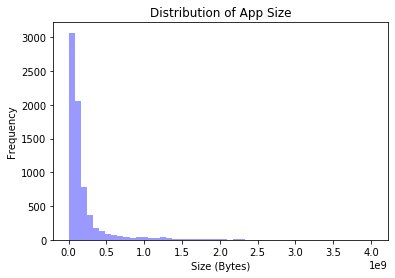

In [6]:
sns.distplot(apps['size_bytes'], hist=True, kde=False, color = 'blue')

# Add labels
plt.title('Distribution of App Size')
plt.xlabel('Size (Bytes)')
plt.ylabel('Frequency')

#### Most of the apps are 1/2 of a Byte or less.

### App Price Distribution

Text(0, 0.5, 'Frequency')

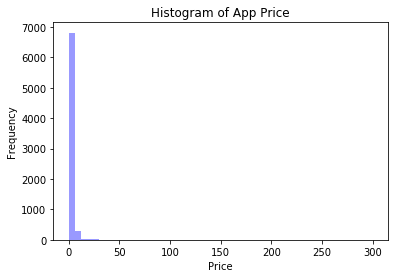

In [7]:
sns.distplot(apps['price'], hist=True, kde=False, color = 'blue')

# Add labels
plt.title('Histogram of App Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

### Free vs Paid Apps

In [8]:
# Create dummy variable that represents free (0) vs paid (1) apps
apps['is_free'] = np.where(apps['price'] > 0, 1, 0)

In [9]:
# Get count of free apps
apps['is_free'][apps['is_free'] == 0].count()

4056

In [10]:
# Get count of paid apps
apps['is_free'][apps['is_free'] == 1].count()

3141

Text(0, 0.5, 'Count')

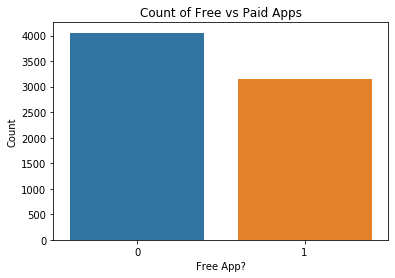

In [11]:
sns.countplot(x='is_free', data=apps)

# Add labels
plt.title('Count of Free vs Paid Apps')
plt.xlabel('Free App?')
plt.ylabel('Count')

#### It appears we have predominantly free (4056) apps compared to paid (3141) ones.

### Total Ratings Count Distribution

Text(0, 0.5, 'Frequency')

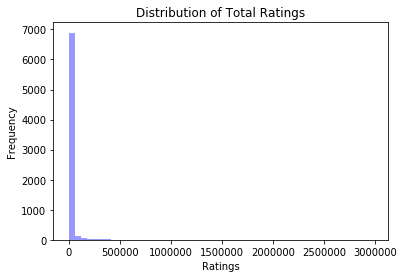

In [12]:
sns.distplot(apps['rating_count_tot'], hist=True, kde=False, color = 'blue')

# Add labels
plt.title('Distribution of Total Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')

In [13]:
# Get maximum number of ratings of an app
apps['rating_count_tot'].max()

2974676

#### Unsurprisingly, the vast majority of the applications have a low ratings count, although one app has a count of 2974676!

### Current Version Ratings Count Distribution

Text(0, 0.5, 'Frequency')

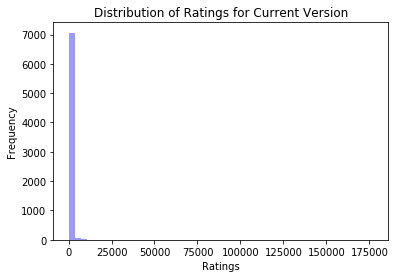

In [14]:
sns.distplot(apps['rating_count_ver'], hist=True, kde=False, color = 'blue')

# Add labels
plt.title('Distribution of Ratings for Current Version')
plt.xlabel('Ratings')
plt.ylabel('Frequency')

#### The same is true for the current version for most apps.

### User Ratings Distribution

Text(0, 0.5, 'Count')

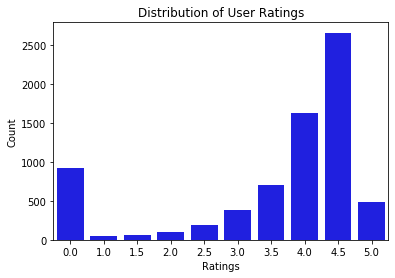

In [15]:
sns.countplot(x='user_rating', data=apps, color = 'blue')

# Add labels
plt.title('Distribution of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')

#### Applications receieve ratings of between 1-5 stars in increments of 0.5. Applications with a rating of 0 have not been rated. It appears as though the majority of apps have a rating of 4 or above.

### Current Version User Ratings Distribution

Text(0, 0.5, 'Count')

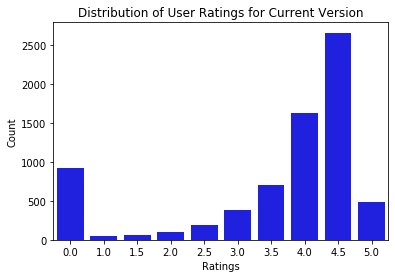

In [16]:
sns.countplot(x='user_rating', data=apps, color = 'blue')

# Add labels
plt.title('Distribution of User Ratings for Current Version')
plt.xlabel('Ratings')
plt.ylabel('Count')

#### The distribution for the current version appears to mirror that of the general ratings distribution.

### Version Distribution

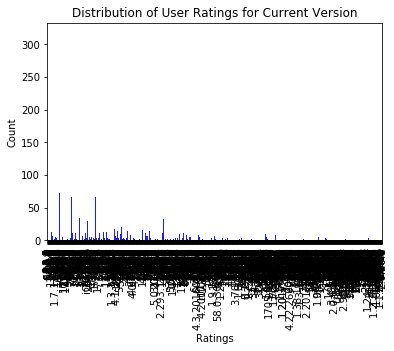

In [17]:
sns_plt = sns.countplot(x='ver', data=apps, color = 'blue')
sns_plt.set_xticklabels(sns_plt.get_xticklabels(), rotation = 90);

# Add labels
plt.title('Distribution of User Ratings for Current Version')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

#### This variable is essentially unintelligible due to the lack of consistent structure in versioning as well as the fact that some versions contain strings. We will rectify this later.

### Content Rating Count

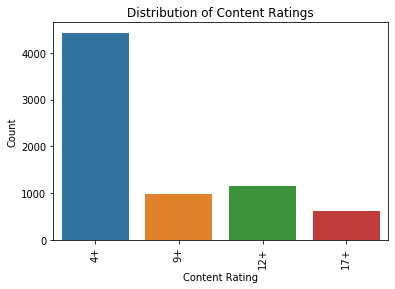

In [18]:
sns_plt = sns.countplot(x='cont_rating', data=apps, order = ['4+','9+','12+','17+'])
sns_plt.set_xticklabels(sns_plt.get_xticklabels(), rotation = 90);

# Add labels
plt.title('Distribution of Content Ratings')
plt.xlabel('Content Rating')
plt.ylabel('Count')
plt.show()

#### It appeasrs the vast majority of the apps having a rating of '4+' indicating that they are essentially for everyone.

### Prime Genre Count

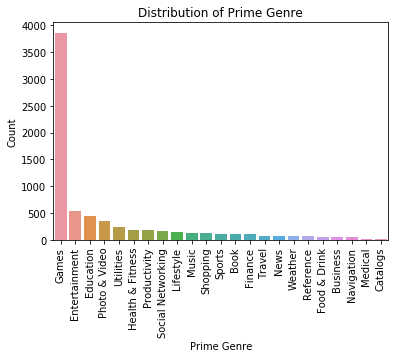

In [19]:
sns_plt = sns.countplot(x='prime_genre', data=apps, order = apps['prime_genre'].value_counts().index)
sns_plt.set_xticklabels(sns_plt.get_xticklabels(), rotation = 90);

# Add labels
plt.title('Distribution of Prime Genre')
plt.xlabel('Prime Genre')
plt.ylabel('Count')
plt.show()

#### Most of the apps fall into the genre of 'Gaming' with 'Entertainment', 'Education', and 'Photo & Video' falling distantly behind

### Supported Devices Distribution

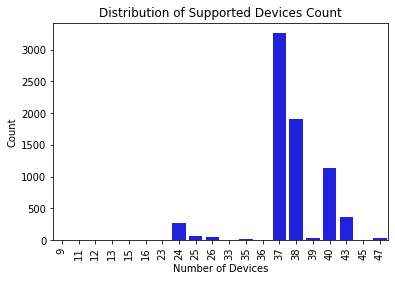

In [20]:
sns_plt = sns.countplot(x='sup_devices_num', data=apps, color = 'blue')
sns_plt.set_xticklabels(sns_plt.get_xticklabels(), rotation = 90);

# Add labels
plt.title('Distribution of Supported Devices Count')
plt.xlabel('Number of Devices')
plt.ylabel('Count')
plt.show()

#### It seems that a most applications support at least 37 devices.

### Number of Screenshots on Page Distribution

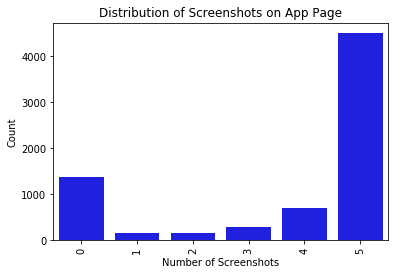

In [21]:
sns_plt = sns.countplot(x='images_num', data=apps, color = 'blue')
sns_plt.set_xticklabels(sns_plt.get_xticklabels(), rotation = 90);

# Add labels
plt.title('Distribution of Screenshots on App Page')
plt.xlabel('Number of Screenshots')
plt.ylabel('Count')
plt.show()

#### Most apps have 5 screenshots which makes sense; likely the owner wants to show off as much functionality as possible.

### Number of Supported Languages Distribution

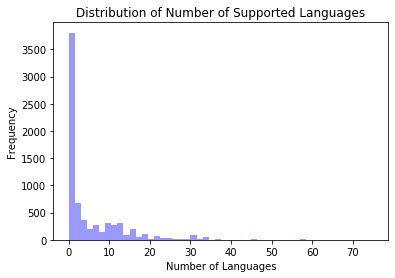

In [22]:
sns.distplot(apps['lang_num'], hist=True, kde=False, color = 'blue')

# Add labels
plt.title('Distribution of Number of Supported Languages')
plt.xlabel('Number of Languages')
plt.ylabel('Frequency')
plt.show()

In [23]:
# Get maximum number of languages supported
apps['lang_num'].max()

75

In [24]:
# Get number of apps that support 1 language
apps['lang_num'][apps['lang_num'] == 1].count()

3767

In [25]:
# Get number of apps that support 0 languages
apps['lang_num'][apps['lang_num'] == 0].count()

41

#### Most apps support 1 language (but some appear to support as many as 75!

### Pairwise Plot of Numeric Variables

#### Subset apps data set to just numeric variables
apps_numeric = apps[['size_bytes', 'price', 'rating_count_tot', 'rating_count_ver', 'sup_devices_num', 'images_num', 'lang_num', 'is_free']].copy()
sns.pairplot(apps_numeric);

## Data Cleaning

### I began the process of data cleaning by removing strings from numeric columns, removing empty columns, and looking for NA values. Next I performed some feature engineering in order to make some continuous variables more accesible. Finally, I created a target dummy variable consisting of a binary indication of whether an application was rated greater than or equal to 4/5.

### Truncate all versions to their first number and drop rows which contain strings in their version numbers (there are only 8), combine versions with leading 0's

In [26]:
apps['ver'] = apps['ver'].str.split('.').str[0]

In [27]:
apps['ver'][apps['ver'] == '00'] = '0'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [28]:
apps = apps[pd.to_numeric(apps['ver'], errors='coerce').notnull()]
apps['ver'] = apps['ver'].astype(int)

#### Replot the distribution of versions

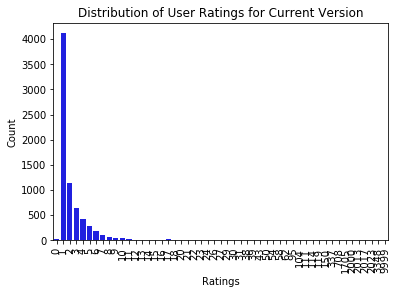

In [29]:
sns_plt = sns.countplot(x='ver', data=apps, color = 'blue')
sns_plt.set_xticklabels(sns_plt.get_xticklabels(), rotation = 90);

# Add labels
plt.title('Distribution of User Ratings for Current Version')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [30]:
apps.ver.unique()

array([   6,    8,    5,    7,    1,    3,    4,   27,   21,   95,   11,
          9,    2,   10,   24,   17,   12,    0,  114,   50,   22, 2013,
         39,  337,   38,   14,   13,  111,   16, 2017,   23,  119,   58,
       2023,   31,   30, 1705,   18, 3348,   54,  150, 2000,   29,   15,
         43,  708,   20, 9999,   62,  104,   26], dtype=int64)

### Check for NA values

In [31]:
apps.isnull().any()

Unnamed: 0          False
track_name          False
size_bytes          False
price               False
rating_count_tot    False
rating_count_ver    False
user_rating         False
user_rating_ver     False
ver                 False
cont_rating         False
prime_genre         False
sup_devices_num     False
images_num          False
lang_num            False
is_free             False
dtype: bool

### Reset index of data frame

In [32]:
apps.reset_index(drop = True, inplace = True)

### View final data frame

In [33]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7189 entries, 0 to 7188
Data columns (total 15 columns):
Unnamed: 0          7189 non-null int64
track_name          7189 non-null object
size_bytes          7189 non-null int64
price               7189 non-null float64
rating_count_tot    7189 non-null int64
rating_count_ver    7189 non-null int64
user_rating         7189 non-null float64
user_rating_ver     7189 non-null float64
ver                 7189 non-null int32
cont_rating         7189 non-null object
prime_genre         7189 non-null object
sup_devices_num     7189 non-null int64
images_num          7189 non-null int64
lang_num            7189 non-null int64
is_free             7189 non-null int32
dtypes: float64(3), int32(2), int64(7), object(3)
memory usage: 786.4+ KB


In [34]:
apps.head()

,Unnamed: 0,track_name,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices_num,images_num,lang_num,is_free
0,1,PAC-MAN Premium,100788224,3.99,21292,26,4.0,4.5,6,4+,Games,38,5,10,1
1,2,Evernote - stay organized,158578688,0.00,161065,26,4.0,3.5,8,4+,Productivity,37,5,23,0
2,3,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,2822,3.5,4.5,5,4+,Weather,37,5,3,0
3,4,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,0.00,262241,649,4.0,4.5,5,12+,Shopping,37,5,9,0
4,5,Bible,92774400,0.00,985920,5320,4.5,5.0,7,4+,Reference,37,5,45,0


#### Having cleaned the data and viewed the final product, I then moved on to exploring the data and asking some analytical questions. Three of the more interesting ones (and their results) are as follows.

## Data Questions

## Question I: Do expensive apps tend to receive high ratings?

#### Create a new dataframe of apps with user ratings

In [35]:
q1 = apps[['price', 'user_rating']][apps['user_rating'] != 0].copy()

#### Create plot of ratings for apps with reviews vs price

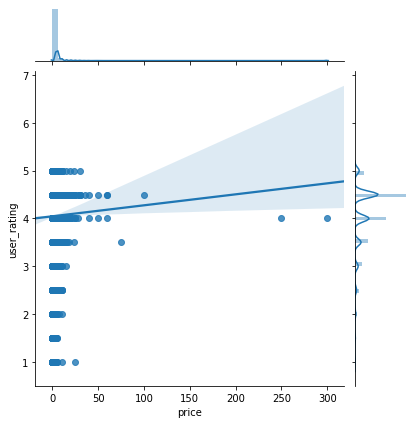

In [36]:
sns.jointplot(x='price', y='user_rating', data=q1, kind='reg');

#### There seems to be a slight degree of correlation between a higher price and a higher rating at a rating of 4 and above.

## Question II: What genre has the highest percentage of highly rated apps?

#### Create a subset of data for apps that have ratings and then calculate the average rating for each category

In [37]:
q2 = apps[['prime_genre', 'user_rating']][apps['user_rating'] != 0].copy()
q2 = q2.groupby('prime_genre').mean()
q2 = q2[['user_rating']]
q2 = q2.sort_values('user_rating')

#### Plot average user rating for each category

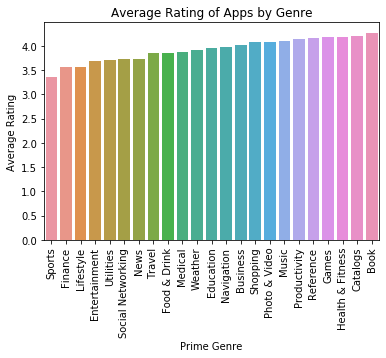

In [38]:
sns_plt = sns.barplot(x='prime_genre',y='user_rating', data=q2.reset_index())
sns_plt.set_xticklabels(sns_plt.get_xticklabels(), rotation = 90);

# Add labels
plt.title('Average Rating of Apps by Genre')
plt.xlabel('Prime Genre')
plt.ylabel('Average Rating')
plt.show()

#### It appears as though the 'Book' category recieves the highest rating on average followed by 'Catalogs', both of which fall at a rating of 4.2/5. On the low end, the 'Sports' category garners an average rating of just 3.4/5.

## Question III: Do apps with more reviews receive higher ratings?

#### Create a subset of data for apps that have ratings

In [39]:
q3 = apps[['rating_count_tot', 'user_rating']][apps['user_rating'] != 0].copy()

#### Create plot of ratings for apps with reviews vs price

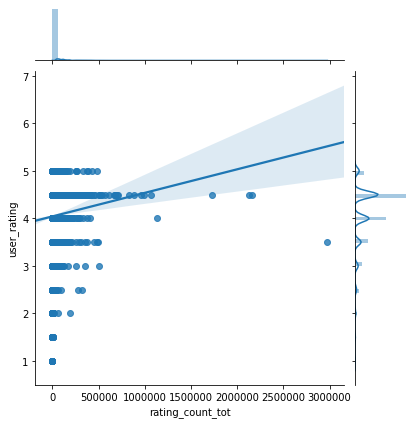

In [40]:
sns.jointplot(x='rating_count_tot', y='user_rating', data=q3, kind='reg');

#### In this case, it appears that a higher number of reviews has a correlation with a higher user rating, but only for apps with a rating of 3.5 or above

### Having investigated the data, I now felt prepared to begin the process of predictive modeling. Using the Logistic Regression and Random Forest algorithms, I will now predict which apps will recieve a rating of above 4 utilizing the other available variables.

## Predictive Modeling

### Can we predict highly rated apps (defined as a rating of 4 or higher)?

#### Subset data to just those apps which recieved reviews

In [41]:
apps = apps[apps['user_rating'] != 0]
apps.reset_index(inplace=True)

#### Create target variable for highly rated apps

In [42]:
apps['target'] = np.where(apps['user_rating'] > 4, 1, 0)

#### Label encode content ratings

In [43]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb_ratings = lb.fit_transform(apps['cont_rating'])
df_ratings = pd.DataFrame(lb_ratings, columns=lb.classes_)
df_ratings = df_ratings.add_prefix('cont_rating_')

#### Label encode genres

In [44]:
lb_genres = lb.fit_transform(apps['prime_genre'])
df_genres = pd.DataFrame(lb_genres, columns=lb.classes_)
df_genres = df_genres.add_prefix('prime_genre_')

#### Recombine data

In [45]:
en_apps = pd.concat([apps, df_ratings, df_genres], axis=1)
en_apps.head()

,index,Unnamed: 0,track_name,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,...,prime_genre_News,prime_genre_Photo & Video,prime_genre_Productivity,prime_genre_Reference,prime_genre_Shopping,prime_genre_Social Networking,prime_genre_Sports,prime_genre_Travel,prime_genre_Utilities,prime_genre_Weather
0,0,1,PAC-MAN Premium,100788224,3.99,21292,26,4.0,4.5,6,...,0,0,0,0,0,0,0,0,0,0
1,1,2,Evernote - stay organized,158578688,0.00,161065,26,4.0,3.5,8,...,0,0,1,0,0,0,0,0,0,0
2,2,3,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,2822,3.5,4.5,5,...,0,0,0,0,0,0,0,0,0,1
3,3,4,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,0.00,262241,649,4.0,4.5,5,...,0,0,0,0,1,0,0,0,0,0
4,4,5,Bible,92774400,0.00,985920,5320,4.5,5.0,7,...,0,0,0,1,0,0,0,0,0,0


### Drop unused columns

In [46]:
en_apps = en_apps.drop('track_name', 1)
en_apps = en_apps.drop('Unnamed: 0', 1)
en_apps = en_apps.drop('prime_genre', 1)
en_apps = en_apps.drop('cont_rating', 1)
en_apps = en_apps.drop('ver', 1)
en_apps = en_apps.drop('user_rating', 1)
en_apps = en_apps.drop('user_rating_ver', 1)
en_apps = en_apps.drop('index', 1)

### Check results

In [47]:
en_apps.head()

,size_bytes,price,rating_count_tot,rating_count_ver,sup_devices_num,images_num,lang_num,is_free,target,cont_rating_12+,...,prime_genre_News,prime_genre_Photo & Video,prime_genre_Productivity,prime_genre_Reference,prime_genre_Shopping,prime_genre_Social Networking,prime_genre_Sports,prime_genre_Travel,prime_genre_Utilities,prime_genre_Weather
0,100788224,3.99,21292,26,38,5,10,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,158578688,0.00,161065,26,37,5,23,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,100524032,0.00,188583,2822,37,5,3,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,128512000,0.00,262241,649,37,5,9,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,92774400,0.00,985920,5320,37,5,45,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [48]:
en_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6261 entries, 0 to 6260
Data columns (total 36 columns):
size_bytes                       6261 non-null int64
price                            6261 non-null float64
rating_count_tot                 6261 non-null int64
rating_count_ver                 6261 non-null int64
sup_devices_num                  6261 non-null int64
images_num                       6261 non-null int64
lang_num                         6261 non-null int64
is_free                          6261 non-null int32
target                           6261 non-null int32
cont_rating_12+                  6261 non-null int32
cont_rating_17+                  6261 non-null int32
cont_rating_4+                   6261 non-null int32
cont_rating_9+                   6261 non-null int32
prime_genre_Book                 6261 non-null int32
prime_genre_Business             6261 non-null int32
prime_genre_Catalogs             6261 non-null int32
prime_genre_Education            6261 non-n

### Split data into train and test sets

In [49]:
X = en_apps.loc[:, en_apps.columns != 'target'].values
y = en_apps.loc[:, en_apps.columns == 'target'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 151)

### Create Random Forest Model

#### Utilize Cross Validation and Grid Search to create an optimized Random Forest model using Area Under Curve for scoring

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state = 151)

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyper = dict(n_estimators = n_estimators,
             max_depth = max_depth,  
             min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

grid = GridSearchCV(rf, 
                    hyper, 
                    cv = 5, 
                    verbose = 1, 
                    n_jobs = -1,
                    scoring='roc_auc')

opt_hyper = grid.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  6.4min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:715: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



#### Utilize optimized Random Forest model on test data

In [51]:
opt_rf = opt_hyper.best_estimator_
                                   
opt_model = opt_rf.fit(X_train, y_train)
y_pred = opt_model.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



#### Get Area Under Curve for optimized model

In [52]:
from sklearn import metrics

print("AUC:",metrics.roc_auc_score(y_test, y_pred))

AUC: 0.676439637160475


#### With our optimized model we are able to achieve an AUC score of 67%, not bad.

### View Feature Importances

In [53]:
feature_importances = pd.DataFrame(opt_rf.feature_importances_,
                                   index = en_apps.loc[:, en_apps.columns != 'target'].columns.values,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [54]:
feature_importances.head(10)

,importance
rating_count_tot,0.239798
rating_count_ver,0.185941
size_bytes,0.150228
lang_num,0.081850
sup_devices_num,0.056474
price,0.048473
images_num,0.039067
prime_genre_Games,0.029780
prime_genre_Entertainment,0.020395
is_free,0.015669


In [55]:
feature_importances.reset_index(inplace=True)
feature_importances = feature_importances.rename(columns={'index': 'feature'}).head(10)
feature_importances

,feature,importance
0,rating_count_tot,0.239798
1,rating_count_ver,0.185941
2,size_bytes,0.150228
3,lang_num,0.081850
4,sup_devices_num,0.056474
5,price,0.048473
6,images_num,0.039067
7,prime_genre_Games,0.029780
8,prime_genre_Entertainment,0.020395
9,is_free,0.015669


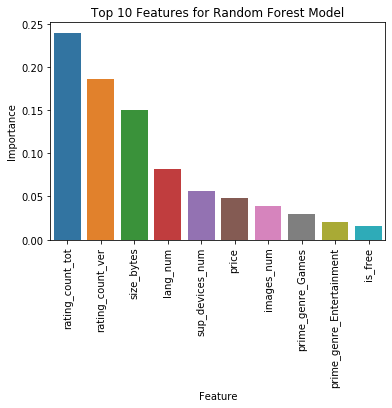

In [56]:
sns_plt = sns.barplot(x='feature', y='importance', data=feature_importances)
sns_plt.set_xticklabels(sns_plt.get_xticklabels(), rotation = 90);

# Add labels
plt.title('Top 10 Features for Random Forest Model')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

#### Judging by the features importances generated by our optimized Random Forest model, rating count in general and for the current app version are the most important indicators of a high overall review score followed by size in bytes and the number of supported languages.